In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

In [2]:
# --- 設定 ---
csv_file = "block_analysis.csv"
output_file_rank = "proposer_rank_distribution.png"
output_file_interval_20 = "block_interval_distribution_20.png"
output_file_interval_100 = "block_interval_distribution_100.png"
output_file_scatter = "interval_vs_rank_scatter.png"

📊 ランク頻度分布を保存しました: proposer_rank_distribution.png


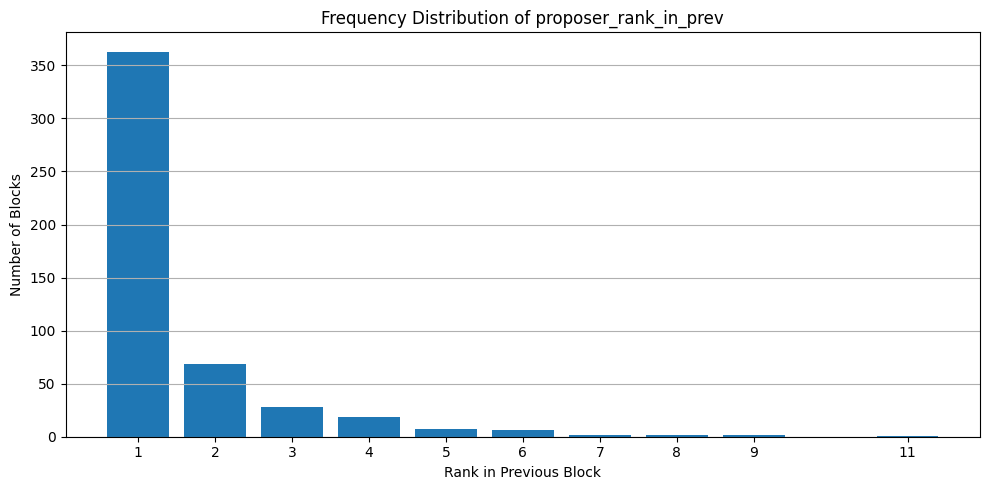

In [3]:
# --- データ読み込み ---
df = pd.read_csv(csv_file)

# --- proposer_rank_in_prev の頻度分布 ---
rank_counts = Counter(df["proposer_rank_in_prev"].dropna().astype(int))
ranks, counts = zip(*sorted(rank_counts.items()))

plt.figure(figsize=(10, 5))
plt.bar(ranks, counts)
plt.title("Frequency Distribution of proposer_rank_in_prev")
plt.xlabel("Rank in Previous Block")
plt.ylabel("Number of Blocks")
plt.xticks(ranks)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(output_file_rank)
print(f"📊 ランク頻度分布を保存しました: {output_file_rank}")

In [4]:
# --- ブロック生成時間間隔（秒） ---
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df["block_interval_sec"] = df["timestamp"].diff().dt.total_seconds()
intervals = df["block_interval_sec"].dropna()

⏱️ ヒストグラム（100分割）保存しました: block_interval_distribution_100.png


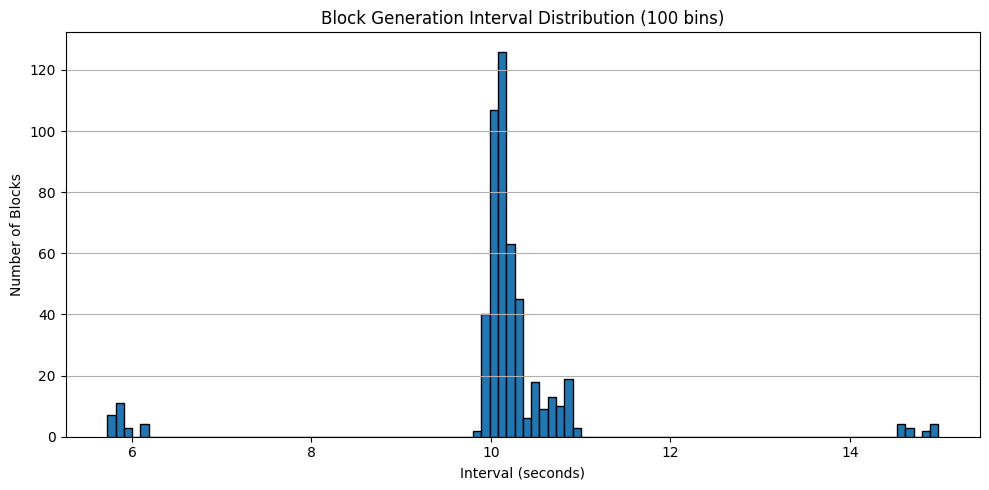

In [5]:
# ヒストグラム描画（100 bins）
plt.figure(figsize=(10, 5))
plt.hist(intervals, bins=100, edgecolor='black')
plt.title("Block Generation Interval Distribution (100 bins)")
plt.xlabel("Interval (seconds)")
plt.ylabel("Number of Blocks")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(output_file_interval_100)
print(f"⏱️ ヒストグラム（100分割）保存しました: {output_file_interval_100}")


📈 Block Generation Interval Statistics:
  Count     : 499
  Mean      : 10.111 sec
  Median    : 10.131 sec
  Std Dev   : 1.234 sec
  Variance  : 1.523 sec²
🟢 散布図を保存しました: interval_vs_rank_scatter.png


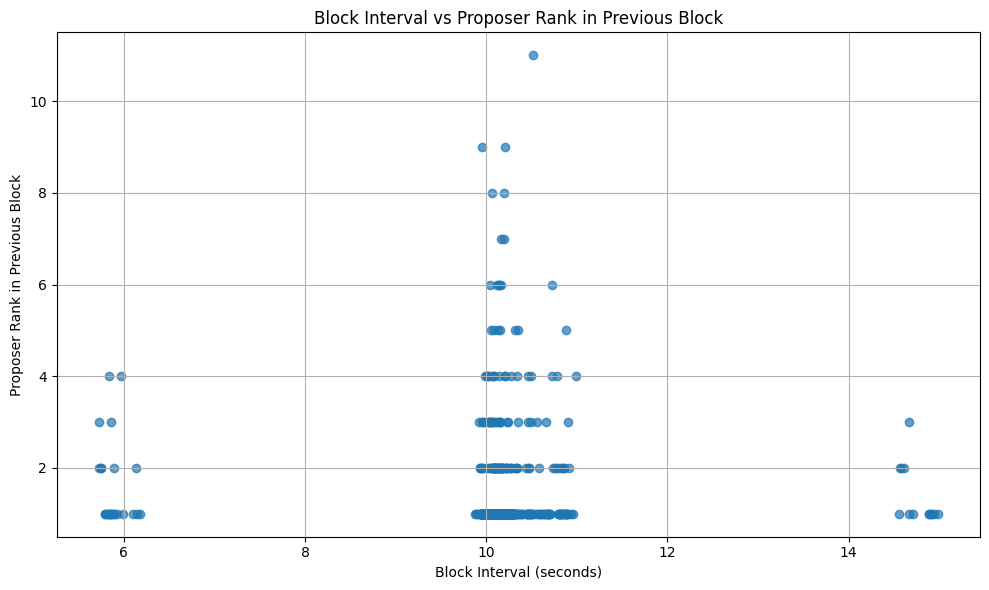

In [6]:
# --- 統計出力 ---
mean_interval = intervals.mean()
median_interval = intervals.median()
std_interval = intervals.std()
var_interval = intervals.var()
count = len(intervals)

print("\n📈 Block Generation Interval Statistics:")
print(f"  Count     : {count}")
print(f"  Mean      : {mean_interval:.3f} sec")
print(f"  Median    : {median_interval:.3f} sec")
print(f"  Std Dev   : {std_interval:.3f} sec")
print(f"  Variance  : {var_interval:.3f} sec²")

# --- 散布図：生成間隔 vs proposer_rank_in_prev ---
scatter_data = df[["block_interval_sec", "proposer_rank_in_prev"]].dropna()

plt.figure(figsize=(10, 6))
plt.scatter(
    scatter_data["block_interval_sec"],
    scatter_data["proposer_rank_in_prev"],
    alpha=0.7
)
plt.title("Block Interval vs Proposer Rank in Previous Block")
plt.xlabel("Block Interval (seconds)")
plt.ylabel("Proposer Rank in Previous Block")
plt.grid(True)
plt.tight_layout()
plt.savefig(output_file_scatter)
print(f"🟢 散布図を保存しました: {output_file_scatter}")

In [7]:
# --- 閾値ごとの分析 + グラフ生成 ---
def analyze_long_blocks(threshold_sec: float):
    df_filtered = df[df["block_interval_sec"] >= threshold_sec]
    print(f"\n🔍 ブロック生成間隔 >= {threshold_sec:.1f}秒 の分析結果:")
    print(f"  対象ブロック数            : {len(df_filtered)}")
    print(f"  平均生成間隔              : {df_filtered['block_interval_sec'].mean():.3f} 秒")
    print(f"  平均 proposer_rank        : {df_filtered['proposer_rank_in_prev'].mean():.2f}")
    print(f"  matches_prev_max_priority : {df_filtered['matches_prev_max_priority'].value_counts().to_dict()}")
    print(f"  matches_min_priority      : {df_filtered['matches_min_priority'].value_counts().to_dict()}")

    # proposer の頻度
    top_proposers = df_filtered["proposer_address"].value_counts().head(5)
    print(f"\n🏷️ Top 5 proposer_address（生成間隔 >= {threshold_sec:.1f}秒）:")
    for addr, count in top_proposers.items():
        print(f"  {addr} : {count} blocks")

    # proposerごとの統計
    total_blocks = len(df)
    proposer_counts = df["proposer_address"].value_counts()
    long_counts = df_filtered["proposer_address"].value_counts()

    summary_list = []
    labels = []
    values = []

    for proposer in proposer_counts.index:
        total = proposer_counts[proposer]
        over = long_counts.get(proposer, 0)
        total_ratio = (total / total_blocks) * 100
        over_ratio = (over / total) * 100
        summary_list.append((proposer, total, total_ratio, over, over_ratio))
        if over > 0:
            labels.append(proposer[:8])  # 短縮表示
            values.append(over_ratio)

    summary_list = sorted(summary_list, key=lambda x: x[3], reverse=True)

    print(f"\n📊 proposer ごとのブロック統計（生成間隔 >= {threshold_sec:.1f}秒）:")
    print(f"{'Proposer Address':<42} | Prop | %Total | ≥{threshold_sec:.1f}s | %≥{threshold_sec:.1f}s")
    print("-" * 80)
    for proposer, total, tratio, over, oratio in summary_list[:10]:
        print(f"{proposer:<42} | {total:4d} | {tratio:6.2f}% | {over:4d} | {oratio:6.1f}%")

In [8]:
# --- 実行 ---
analyze_long_blocks(6)
analyze_long_blocks(12)
analyze_long_blocks(15)
analyze_long_blocks(18)

# --- proposer のブロック生成速度スコア分析 ---
output_file_speed_csv = "proposer_speed_scores.csv"
output_file_speed_plot = "proposer_speed_scores.png"

print("\n⚡ proposer のブロック生成速度スコア:")

speed_stats = []
for proposer in df["proposer_address"].unique():
    intervals = df.loc[df["proposer_address"] == proposer, "block_interval_sec"].dropna()
    if len(intervals) == 0:
        continue
    avg_interval = intervals.mean()
    score = 1 / avg_interval if avg_interval > 0 else 0
    speed_stats.append({
        "proposer_address": proposer,
        "count": len(intervals),
        "avg_interval": avg_interval,
        "speed_score": score
    })


🔍 ブロック生成間隔 >= 6.0秒 の分析結果:
  対象ブロック数            : 478
  平均生成間隔              : 10.299 秒
  平均 proposer_rank        : 1.58
  matches_prev_max_priority : {True: 350, False: 128}
  matches_min_priority      : {False: 478}

🏷️ Top 5 proposer_address（生成間隔 >= 6.0秒）:
  C27B627C2FD11EE1E3E850738720692BE2E3F4C6 : 22 blocks
  3C70D8336DEE739BDF2D1C5A0FCA0A88B87B9A6D : 21 blocks
  44C395A4A96C6D1A450ED33B5A8DDB359CEFED36 : 20 blocks
  2A3D40C3E7CE8D6B55077335CAB141C2E11AC254 : 20 blocks
  64CDACB04FB9C3B290579644F9EDBD05CB00BB7D : 20 blocks

📊 proposer ごとのブロック統計（生成間隔 >= 6.0秒）:
Proposer Address                           | Prop | %Total | ≥6.0s | %≥6.0s
--------------------------------------------------------------------------------
C27B627C2FD11EE1E3E850738720692BE2E3F4C6   |   23 |   4.60% |   22 |   95.7%
3C70D8336DEE739BDF2D1C5A0FCA0A88B87B9A6D   |   23 |   4.60% |   21 |   91.3%
33ECD5899A91105BB4E51066EB138189BC3825AD   |   22 |   4.40% |   20 |   90.9%
64CDACB04FB9C3B290579644F9EDBD05CB00BB7D 

📁 proposer スピードスコアを CSV に保存しました: proposer_speed_scores.csv
📊 スピードスコア上位20のグラフを保存しました: proposer_speed_scores.png


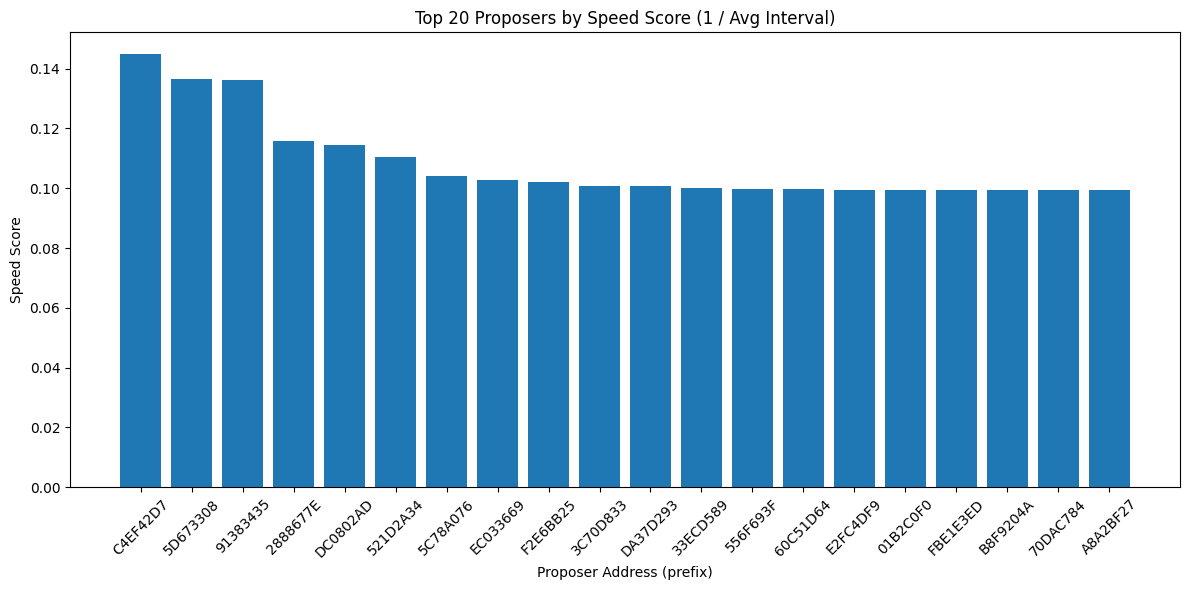

In [9]:
# DataFrame に変換して保存
speed_df = pd.DataFrame(speed_stats)
speed_df.sort_values(by="speed_score", ascending=False, inplace=True)
speed_df.to_csv(output_file_speed_csv, index=False, encoding="utf-8-sig")
print(f"📁 proposer スピードスコアを CSV に保存しました: {output_file_speed_csv}")

# グラフ化（上位20）
top_speed = speed_df.head(20)
plt.figure(figsize=(12, 6))
plt.bar(top_speed["proposer_address"].str[:8], top_speed["speed_score"])
plt.title("Top 20 Proposers by Speed Score (1 / Avg Interval)")
plt.xlabel("Proposer Address (prefix)")
plt.ylabel("Speed Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_file_speed_plot)
print(f"📊 スピードスコア上位20のグラフを保存しました: {output_file_speed_plot}")